In [1]:
import os, glob
import numpy as np 
import matplotlib.pyplot as plt
import cv2


In [ ]:
imgs_folder= 'new-IDR'
imgs_fns= sorted(os.listdir(imgs_folder))

x_tiles= sorted(list(set([int(fn.split('.')[0].split('_')[0]) for fn in imgs_fns])))
y_tiles= sorted(list(set([int(fn.split('.')[0].split('_')[1].replace(' (1)', '')) for fn in imgs_fns])))

In [ ]:
import os
import numpy as np
import cv2

imgs_folder = imgs_folder

# Collect all image filenames
imgs_fns = set(os.listdir(imgs_folder))

# Get unique sorted x and y from filenames
x_vals, y_vals = set(), set()
for fn in imgs_fns:
    try:
        x, y = map(int, fn.replace(".jpg", "").split("_"))
        x_vals.add(x)
        y_vals.add(y)
    except:
        continue

x_tiles = sorted(x_vals)
y_tiles = sorted(y_vals)

tile_h, tile_w = 256, 256
rows = []

for y in y_tiles:
    row_patches = []
    for x in x_tiles:
        fn = f"{x}_{y}.jpg"
        if fn in imgs_fns:
            patch = cv2.cv2.imread(f"{imgs_folder}/{fn}")
            patch = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
        else:
            patch = np.zeros((tile_h, tile_w, 3), dtype=np.uint8)  # black tile
        row_patches.append(patch)
    
    row = np.hstack(row_patches)
    rows.append(row)

# Final image
big_img = np.vstack(rows)

# Save or show
cv2.imwrite("stitched_result.jpg", cv2.cvtColor(big_img, cv2.COLOR_RGB2BGR))


In [4]:
big_img.shape

(36352, 39680, 3)

In [1]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Désactive la protection


In [2]:
img= Image.open('/home/adelb/Documents/Bpartners/Plantes Invasive/stitched_image_x_horizontal.jpg')
tile_size = 1024                 # taille d'une tuile : 1024 x 1024 pixels

for top in range(0, img.height, tile_size):            # on parcourt l'image ligne par ligne
    for left in range(0, img.width, tile_size):        # on parcourt chaque colonne
        box = (left, top, left + tile_size, top + tile_size)  # on définit un rectangle (tuile)
        tile = img.crop(box)                           # on extrait juste cette tuile de l'image
        # traitement de la tuile, par exemple :
        tile.save(f"tiles/tile_{top}_{left}.jpg")


In [3]:
import os
from PIL import Image

image_dir = imgs_folder
tile_size = 256

images = {}
x_vals = set()
y_vals = set()

# Step 1: Parse filenames and collect (x, y)
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        try:
            x_str, y_str = os.path.splitext(filename)[0].split("_")
            x, y = int(x_str), int(y_str)
            images[(x, y)] = os.path.join(image_dir, filename)
            x_vals.add(x)
            y_vals.add(y)
        except Exception as e:
            print(f"Skipping {filename}: {e}")

# Step 2: Sort and map x and y positions
sorted_x = sorted(x_vals)  # Horizontal
sorted_y = sorted(y_vals)  # Vertical

x_to_col = {x: i for i, x in enumerate(sorted_x)}
y_to_row = {y: i for i, y in enumerate(sorted_y)}

cols = len(sorted_x)
rows = len(sorted_y)
canvas_width = cols * tile_size
canvas_height = rows * tile_size

# Step 3: Create final canvas
final_img = Image.new("RGB", (canvas_width, canvas_height), color=(0, 0, 0))

# Step 4: Paste images to correct positions
for (x, y), path in images.items():
    try:
        img = Image.open(path)
        col = x_to_col[x]  # horizontal position
        row = y_to_row[y]  # vertical position
        final_img.paste(img, (col * tile_size, row * tile_size))
    except Exception as e:
        print(f"Error with image {path}: {e}")

# Step 5: Save result
final_img.save("stitched_image_x_horizontal.jpg")


In [36]:
def print_title(title):
	title= f" {title} "
	g= "#"*80
	print(g)
	print(f"{title:#^80}")
	print(g)

In [39]:
print_title('Group Adjacent Images')

################################################################################
############################ Group Adjacent Images #############################
################################################################################


In [7]:
################################################################################
########################## YOLO Segmentation to Bbox ###########################
################################################################################


import os
import numpy as np
import glob

def polygon_to_bbox(polygon_points):
    """
    Converts a polygon (list of points) to a bounding box in YOLO format (xc, yc, w, h).
    
    Args:
    - polygon_points (list of tuples): List of (x, y) tuples representing the polygon vertices.
    
    Returns:
    - tuple: (xc, yc, w, h) in YOLO format.
    """
    # Extract the x and y coordinates
    x_coords = [point[0] for point in polygon_points]
    y_coords = [point[1] for point in polygon_points]
    
    # Find the min and max coordinates to get the bounding box
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)
    
    # Compute the center and size of the bounding box
    xc = (x_min + x_max) / 2
    yc = (y_min + y_max) / 2
    w = x_max - x_min
    h = y_max - y_min
    
    return xc, yc, w, h

def convert_yolo_segmentation_to_bbox(input_file, output_file, image_width, image_height):
    """
    Converts YOLO segmentation annotations to bounding box annotations in YOLO format.
    
    Args:
    - input_file (str): Path to the input YOLO segmentation annotation file.
    - output_file (str): Path to save the output YOLO bounding box annotation file.
    - image_width (int): Width of the image (for normalization).
    - image_height (int): Height of the image (for normalization).
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            # Split the line by spaces
            parts = line.strip().split()
            class_id = int(parts[0])
            polygon_points = []

            # Convert the polygon points (pairs of x, y)
            for i in range(1, len(parts), 2):
                x = float(parts[i])
                y = float(parts[i + 1])
                polygon_points.append((x, y))
            
            # Convert polygon to bounding box in YOLO format
            xc, yc, w, h = polygon_to_bbox(polygon_points)
            
            # # Normalize the bounding box coordinates (relative to image size)
            # xc /= image_width
            # yc /= image_height
            # w /= image_width
            # h /= image_height
            
            # Write the result to the output file
            outfile.write(f"{class_id} {xc} {yc} {w} {h}\n")

# Example usage
for yolo_txt in glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/*.txt"):
    print(yolo_txt)
    output_annotation_file = f"/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-bbox/{os.path.basename(yolo_txt)}"       # Path to the output YOLO bounding box annotations
    image_width = 256                                    # Image width (in pixels)
    image_height = 256                                  # Image height (in pixels)
    
    convert_yolo_segmentation_to_bbox(yolo_txt, output_annotation_file, image_width, image_height)


/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1040072_744352.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2024_1039866_744435.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1040244_744390.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2024_1039839_744268.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2024_1039868_744434.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1039798_744266.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2023_1039881_744101.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2023_1039776_744023.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1039745_744008.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1039770_744017.txt
/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-labels/2022_1040229_744363.txt
/home/adelb/Documents

In [9]:
################################################################################
############################ Group Adjacent Images #############################
################################################################################

import os, json
import cv2
import numpy as np
from collections import defaultdict
from itertools import product

# Configuration: Paths and parameters
imgs_folder = '/home/adelb/Documents/Bpartners/Plantes Invasive/selected-new-images'  # Folder containing the patch images
output_folder = '/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_images'  # Folder to save stitched images
tile_size = 256  # Each patch size (256x256)
years = [2020, 2022, 2024, 2023]  # The years present in the filenames


# Function to get all the image filenames
def get_image_filenames():
    imgs_fns = [f for f in os.listdir(imgs_folder) if f.endswith('.jpg')]
    return imgs_fns

# Function to get x, y, and year from the filename
def parse_filename(filename):
    year, x, y = map(int, filename.split('.')[0].split('_')[:3])
    return year, x, y

# Group images by adjacency (spatially connected patches for each year)
def group_images_by_adjacency(imgs_fns):
    groups = defaultdict(list)

    # Group by year
    year_groups = defaultdict(lambda: defaultdict(list))  # Fix: positions should be defaultdict(list)
    for fn in imgs_fns:
        year, x, y = parse_filename(fn)
        year_groups[year][(x, y)].append(fn)  # Group by year and (x, y)

    # Group adjacent patches (both horizontally and vertically)
    for year, positions in year_groups.items():
        visited = set()
        for (x, y), filenames in positions.items():
            if (x, y) in visited:
                continue
            group = []
            to_visit = [(x, y)]
            while to_visit:
                cx, cy = to_visit.pop()
                if (cx, cy) in visited:
                    continue
                visited.add((cx, cy))
                group.extend(positions[(cx, cy)])  # Fix: use positions[(cx, cy)] instead of .get()
                # Check neighboring positions (left-right, top-bottom)
                neighbors = [(cx+1, cy), (cx-1, cy), (cx, cy+1), (cx, cy-1)]
                for nx, ny in neighbors:
                    if (nx, ny) in positions:
                        to_visit.append((nx, ny))
            if group:
                groups[year].append(group)

    return groups

# Function to save groups to a JSON file
def save_groups_to_json(groups, output_filename):
    with open(output_filename, 'w') as f:
        json.dump(groups, f, indent=4)
    print(f"Groups saved to {output_filename}")

# Main function to process the images and save groups to JSON
def process_images():
    imgs_fns = get_image_filenames()
    groups = group_images_by_adjacency(imgs_fns)

    output_filename = os.path.join(output_folder, "image_groups.json")
    save_groups_to_json(groups, output_filename)

# Run the process
process_images()




Groups saved to /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_images/image_groups.json


In [12]:
import os, json
import numpy as np
from PIL import Image

# Sample list of filenames
with open("/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_images/image_groups.json") as f:
    year_groups= json.load(f)

def parse_filename(name):
    # Expects format: year_x_y.jpg
    parts = name.replace('.jpg', '').split('_')
    year, x, y = int(parts[0]), int(parts[1]), int(parts[2])
    return year, x, y

for year, groups in year_groups.items():
	for i, filenames in enumerate(groups):
		# Create a dictionary {(x, y): filename}
		coord_to_file = {}
		for fname in filenames:
			_, x, y = parse_filename(fname)
			coord_to_file[(x, y)] = fname

		# Get all unique x and y, sorted appropriately
		xs = sorted(set(x for x, y in coord_to_file))
		ys = sorted(set(y for x, y in coord_to_file))

		# Build a 2D grid of images: rows are y (top to bottom), cols are x (left to right)
		grid = []
		for y in ys:
			row = []
			for x in xs:
				if (x, y) in coord_to_file:
					img = Image.open(f"selected-new-images/{coord_to_file[(x, y)]}")
					row.append(img)
				else:
					# Use a blank image if a patch is missing (optional)
					img_size = row[0].size if row else Image.open(f"selected-new-images/{next(iter(coord_to_file.values()))}").size
					row.append(Image.new("RGB", img_size, color=(0, 0, 0)))
			grid.append(row)

		# Stitch rows horizontally
		stitched_rows = []
		for row in grid:
			row_img = row[0]
			for img in row[1:]:
				row_img = Image.fromarray(
					np.hstack((np.array(row_img), np.array(img)))
				)
			stitched_rows.append(row_img)

		# Stitch the full image vertically
		final_img = stitched_rows[0]
		for row_img in stitched_rows[1:]:
			final_img = Image.fromarray(
				np.vstack((np.array(final_img), np.array(row_img)))
			)

		# Save or show result
		final_img.save(f"/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_images/{year}_group_{i}.jpg")
# final_img.show()


In [13]:
import os

tile_size = 256  # px

def parse_filename(fname):
    name = os.path.splitext(fname)[0]
    year, x, y = name.split("_")
    return year, int(x), int(y)

def stitch_yolo_annotations(dir, txt_files, output_txt_path):
    tiles = []
    for f in txt_files:
        year, x, y = parse_filename(f)
        tiles.append((f, x, y))

    # Sort and map x and y positions to grid indices (columns and rows)
    unique_xs = sorted(set(x for _, x, _ in tiles))  # left to right
    unique_ys = sorted(set(y for _, _, y in tiles))  # top to bottom

    x_to_col = {x: i for i, x in enumerate(unique_xs)}
    y_to_row = {y: i for i, y in enumerate(unique_ys)}

    grid_cols = len(unique_xs)
    grid_rows = len(unique_ys)
    stitched_w = grid_cols * tile_size
    stitched_h = grid_rows * tile_size

    all_annotations = []

    for file, x, y in tiles:
        ffile= f"{dir}/{file}"
        col = x_to_col[x]
        row = y_to_row[y]
        offset_x = col * tile_size
        offset_y = row * tile_size

        with open(ffile, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, cx, cy, w, h = map(float, parts)

                # Convert to absolute pixel values
                abs_cx = cx * tile_size + offset_x
                abs_cy = cy * tile_size + offset_y
                abs_w = w * tile_size
                abs_h = h * tile_size

                # Normalize to stitched image size
                new_cx = abs_cx / stitched_w
                new_cy = abs_cy / stitched_h
                new_w = abs_w / stitched_w
                new_h = abs_h / stitched_h

                all_annotations.append(f"{int(cls)} {new_cx:.6f} {new_cy:.6f} {new_w:.6f} {new_h:.6f}")

    with open(output_txt_path, "w") as out:
        out.write("\n".join(all_annotations))

    print(f"✅ Stitched annotation written to: {output_txt_path}")


In [16]:
for year, groups in year_groups.items():
	dir= "/home/adelb/Documents/Bpartners/Plantes Invasive/all-yolo-bbox"
	for i, jpg_files in enumerate(groups):
		out_file= f"/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/{year}_group_{i}.txt"
		txt_files= [fn.replace('.jpg', '.txt') for fn in jpg_files]
		stitch_yolo_annotations(dir, txt_files, out_file)



✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_0.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_1.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_2.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_3.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_4.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_5.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_6.txt
✅ Stitched annotation written to: /home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/2022_group_7.txt
✅ Stitch

In [13]:
import cv2
import os
import matplotlib.pyplot as plt

def draw_yolo_annotations(image_path, txt_path, class_names=None, show = True, box_color=(0, 255, 0), thickness=2):
    # Load image
    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    # Read annotation file
    if not os.path.exists(txt_path):
        print(f"Annotation file not found: {txt_path}")
        return image

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if not line.strip():
            continue
        parts = line.strip().split()
        if len(parts) != 5:
            continue  # skip malformed lines

        cls_id, cx, cy, bw, bh = map(float, parts)

        # Convert normalized coordinates to pixel values
        cx *= w
        cy *= h
        bw *= w
        bh *= h

        # Get top-left and bottom-right corners
        x1 = int(cx - bw / 2)
        y1 = int(cy - bh / 2)
        x2 = int(cx + bw / 2)
        y2 = int(cy + bh / 2)

        # Draw rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), box_color, thickness)

        # Add class label if available
        if class_names and int(cls_id) < len(class_names):
            label = class_names[int(cls_id)]
        else:
            label = str(int(cls_id))

        # Put label text
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color, 1)
	
    h, w, _ = image.shape
    r= w/h
    
    bn = os.path.basename(image_path)
    if show:
        plt.figure(figsize=(6, int(10/r)))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.tight_layout()
        plt.axis('off')
        plt.show()
    else:
        cv2.imwrite(f'figs2/{bn}', image)


In [3]:
from random import choice
import glob

classes = ['Baccharis', 'Herbe de la Pampa']

img_paths = sorted(glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_images/*.jpg"))
txt_paths = sorted(glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/*.txt"))


for img_path, txt_path in zip(img_paths, txt_paths):
    annotated_image = draw_yolo_annotations(img_path, txt_path, class_names=classes)

In [46]:
import os
import numpy as np

def yolo_to_xyxy(xc, yc, w, h, img_w, img_h):
    """Convert YOLO (xc, yc, w, h) to pixel-based (x_min, y_min, x_max, y_max)."""
    x_min = (xc - w / 2) * img_w
    y_min = (yc - h / 2) * img_h
    x_max = (xc + w / 2) * img_w
    y_max = (yc + h / 2) * img_h
    return [x_min, y_min, x_max, y_max]

def xyxy_to_yolo(x_min, y_min, x_max, y_max, img_w, img_h):
    """Convert pixel-based (x_min, y_min, x_max, y_max) to YOLO format."""
    xc = (x_min + x_max) / 2 / img_w
    yc = (y_min + y_max) / 2 / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return [xc, yc, w, h]

def boxes_overlap(box1, box2):
    """Check if two boxes (in pixel format) overlap or touch."""
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2
    return not (x1_max < x2_min or x2_max < x1_min or y1_max < y2_min or y2_max < y1_min)

def merge_boxes(boxes):
    """Merge a list of pixel-space boxes into one enclosing box."""
    x_min = min(b[0] for b in boxes)
    y_min = min(b[1] for b in boxes)
    x_max = max(b[2] for b in boxes)
    y_max = max(b[3] for b in boxes)
    return [x_min, y_min, x_max, y_max]

def inflate_box(box, buffer, img_w, img_h):
    """Inflate box by `buffer` pixels on all sides, clipped to image size."""
    x1, y1, x2, y2 = box
    x1 = max(0, x1 - buffer)
    y1 = max(0, y1 - buffer)
    x2 = min(img_w, x2 + buffer)
    y2 = min(img_h, y2 + buffer)
    return [x1, y1, x2, y2]

def group_and_merge_boxes_with_buffer(boxes, buffer, img_w, img_h):
    """Group overlapping/close boxes (buffered) and merge each group."""
    merged = []
    used = [False] * len(boxes)

    for i in range(len(boxes)):
        if used[i]:
            continue
        group = [boxes[i]]
        used[i] = True
        changed = True
        while changed:
            changed = False
            for j in range(len(boxes)):
                if used[j]:
                    continue
                if any(boxes_overlap(inflate_box(b, buffer, img_w, img_h),
                                     inflate_box(boxes[j], buffer, img_w, img_h)) for b in group):
                    group.append(boxes[j])
                    used[j] = True
                    changed = True
        merged.append(merge_boxes(group))
    return merged

def fuse_yolo_bboxes_with_buffer(input_file, output_file, img_w=256, img_h=256, buffer=4):
    """Fuse YOLO bboxes with a pixel buffer (tolerance for close bboxes)."""
    annotations = []
    with open(input_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, img_w, img_h)
            annotations.append((cls, [x1, y1, x2, y2]))

    class_groups = {}
    for cls, box in annotations:
        class_groups.setdefault(cls, []).append(box)

    fused_annotations = []
    for cls, boxes in class_groups.items():
        merged_boxes = group_and_merge_boxes_with_buffer(boxes, buffer, img_w, img_h)
        for mb in merged_boxes:
            xc, yc, w, h = xyxy_to_yolo(*mb, img_w, img_h)
            fused_annotations.append(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    with open(output_file, 'w') as f:
        f.write("\n".join(fused_annotations) + "\n")

def group_and_merge_boxes(boxes):
    """Group overlapping boxes and merge each group into one box."""
    merged = []
    used = [False] * len(boxes)
    
    for i in range(len(boxes)):
        if used[i]:
            continue
        group = [boxes[i]]
        used[i] = True
        
        changed = True
        while changed:
            changed = False
            for j in range(len(boxes)):
                if used[j]:
                    continue
                if any(boxes_overlap(b, boxes[j]) for b in group):
                    group.append(boxes[j])
                    used[j] = True
                    changed = True
        merged.append(merge_boxes(group))
    return merged

def fuse_yolo_bboxes(input_file, output_file, img_w=256, img_h=256):
    # Read YOLO annotations
    annotations = []
    with open(input_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, img_w, img_h)
            annotations.append((cls, [x1, y1, x2, y2]))

    # Group by class
    class_groups = {}
    for cls, box in annotations:
        class_groups.setdefault(cls, []).append(box)

    # Merge overlapping boxes for each class
    fused_annotations = []
    for cls, boxes in class_groups.items():
        merged_boxes = group_and_merge_boxes(boxes)
        for mb in merged_boxes:
            xc, yc, w, h = xyxy_to_yolo(*mb, img_w, img_h)
            fused_annotations.append(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    # Write output
    with open(output_file, 'w') as f:
        f.write("\n".join(fused_annotations) + "\n")

# Example usage
fused_dir = "all_fused_yolo-boxes2"
os.makedirs(fused_dir, exist_ok=True)
for input_txt in glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all_grouped_yolo_bboxes/*.txt"):
	output_txt = f"/home/adelb/Documents/Bpartners/Plantes Invasive/{fused_dir}/{os.path.basename(input_txt)}"
	fuse_yolo_bboxes_with_buffer(input_txt, output_txt, img_w=256, img_h=256, buffer= 0.64)




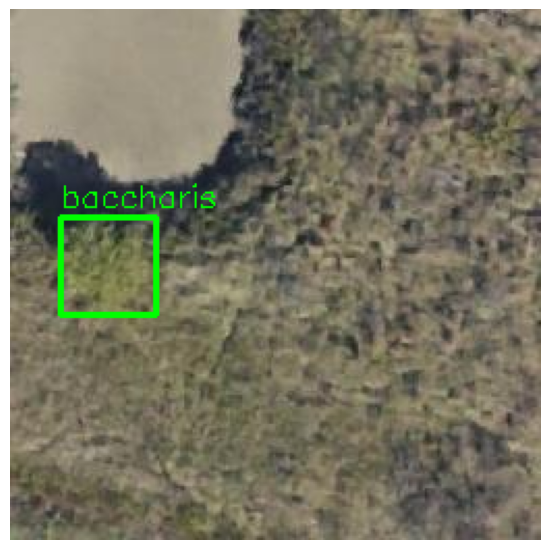

In [73]:
txt_files= glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all_fused_yolo-boxes2/*.txt")
def get_img_path(txt_fp):
    return txt_fp.replace("all_fused_yolo-boxes2", "all_grouped_images").replace(".txt", '.jpg')

from random import choice

classes = ['baccharis', 'pampa']

txt_path = choice(txt_files)
img_path = get_img_path(txt_path)

# txt_iter = iter(txt_files)

# for txt_path in txt_files:
#     img_path = get_img_path(txt_path)
annotated_image = draw_yolo_annotations(img_path, txt_path, class_names=classes)

In [38]:
import os
import cv2

def patchify_with_annotations(image_path, annotation_path, patch_size=256, output_dir="all_patches"):
    os.makedirs(output_dir, exist_ok=True)

    # Load image
    img = cv2.imread(image_path)
    h_img, w_img = img.shape[:2]

    # Read annotations
    annotations = []
    with open(annotation_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            px = xc * w_img
            py = yc * h_img
            pw = w * w_img
            ph = h * h_img
            annotations.append((cls, px, py, pw, ph))

    patch_half = patch_size // 2
    base_name = os.path.splitext(os.path.basename(image_path))[0]

    patch_count = 0
    for cls, px, py, pw, ph in annotations:
        # Compute patch window
        x1 = max(int(px - patch_half), 0)
        y1 = max(int(py - patch_half), 0)
        x2 = min(x1 + patch_size, w_img)
        y2 = min(y1 + patch_size, h_img)

        # Adjust in case the patch is near edges
        if x2 - x1 < patch_size:
            x1 = max(0, x2 - patch_size)
        if y2 - y1 < patch_size:
            y1 = max(0, y2 - patch_size)

        # Crop patch
        patch = img[y1:y2, x1:x2]
        patch_filename = f"{base_name}_patch{patch_count}.jpg"
        patch_txtname = f"{base_name}_patch{patch_count}.txt"
        patch_path = os.path.join(output_dir, patch_filename)
        txt_path = os.path.join(output_dir, patch_txtname)

        cv2.imwrite(patch_path, patch)

        # Gather annotations inside the patch
        patch_annots = []
        for cls2, px2, py2, pw2, ph2 in annotations:
            # Check if center lies within patch
            if x1 <= px2 <= x2 and y1 <= py2 <= y2:
                # Recalculate relative to patch
                new_xc = (px2 - x1) / patch_size
                new_yc = (py2 - y1) / patch_size
                new_w = pw2 / patch_size
                new_h = ph2 / patch_size

                # Only keep if still within patch after crop
                if 0 <= new_xc <= 1 and 0 <= new_yc <= 1:
                    patch_annots.append(f"{cls2} {new_xc:.6f} {new_yc:.6f} {new_w:.6f} {new_h:.6f}")

        # Save patch annotation
        with open(txt_path, "w") as f:
            f.write("\n".join(patch_annots))

        patch_count += 1


In [39]:
import os
import cv2

def yolo_to_bbox(xc, yc, w, h, img_w, img_h):
    """Convert YOLO format to absolute bounding box (x_min, y_min, x_max, y_max)."""
    x_c = xc * img_w
    y_c = yc * img_h
    bw = w * img_w
    bh = h * img_h
    return x_c - bw / 2, y_c - bh / 2, x_c + bw / 2, y_c + bh / 2

def bbox_intersects(b1, b2):
    """Check if two bounding boxes intersect."""
    x1_min, y1_min, x1_max, y1_max = b1
    x2_min, y2_min, x2_max, y2_max = b2
    return not (x1_max <= x2_min or x2_max <= x1_min or y1_max <= y2_min or y2_max <= y1_min)

def patchify_annotations_with_overlap(image_path, annotation_path, patch_size=256, output_dir="patches"):
    os.makedirs(output_dir, exist_ok=True)

    # Load image
    img = cv2.imread(image_path)
    img_h, img_w = img.shape[:2]

    # Read annotations
    annotations = []
    with open(annotation_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            cls = int(parts[0])
            xc, yc, w, h = map(float, parts[1:])
            annotations.append((cls, xc, yc, w, h))

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    patch_half = patch_size // 2
    patch_id = 0

    for cls_center, xc_center, yc_center, w_center, h_center in annotations:
        # Get center in pixels
        px = int(xc_center * img_w)
        py = int(yc_center * img_h)

        # Patch bounds
        x1 = max(0, px - patch_half)
        y1 = max(0, py - patch_half)
        x2 = min(img_w, x1 + patch_size)
        y2 = min(img_h, y1 + patch_size)

        # Fix patch edges if it's too close to borders
        if x2 - x1 < patch_size:
            x1 = max(0, x2 - patch_size)
        if y2 - y1 < patch_size:
            y1 = max(0, y2 - patch_size)

        patch = img[y1:y2, x1:x2]
        patch_filename = f"{base_name}_patch{patch_id}.jpg"
        patch_txtname = f"{base_name}_patch{patch_id}.txt"
        cv2.imwrite(os.path.join(output_dir, patch_filename), patch)

        patch_box = (x1, y1, x2, y2)

        # Rebuild annotation list for this patch
        patch_annotations = []
        for cls, xc, yc, w, h in annotations:
            # Convert to absolute bbox
            bbox = yolo_to_bbox(xc, yc, w, h, img_w, img_h)
            if bbox_intersects(bbox, patch_box):
                # Clip to patch and convert to relative patch coordinates
                x_abs = xc * img_w - x1
                y_abs = yc * img_h - y1
                w_abs = w * img_w
                h_abs = h * img_h

                # Normalize relative to patch size
                new_xc = x_abs / patch_size
                new_yc = y_abs / patch_size
                new_w = w_abs / patch_size
                new_h = h_abs / patch_size

                # if 0 <= new_xc <= 1 and 0 <= new_yc <= 1:
                patch_annotations.append(f"{cls} {new_xc:.6f} {new_yc:.6f} {new_w:.6f} {new_h:.6f}")
                    # patch_annotations.append(f"{cls} {new_xc:.6f} {new_yc:.6f} {new_w:.6f} {new_h:.6f}")

        # Write patch annotation file
        with open(os.path.join(output_dir, patch_txtname), "w") as f:
            f.write("\n".join(patch_annotations))

        patch_id += 1


In [ ]:
tst_img= "/home/adelb/Documents/Bpartners/Plantes Invasive/stitched_1_result.jpg"
tst_txt= "/home/adelb/Documents/Bpartners/Plantes Invasive/fused_annotations.txt"
patchify_annotations_with_overlap(
    image_path=tst_img,
    annotation_path=tst_txt,
    patch_size=256,
    output_dir="all_patches_256"
)

In [40]:
for txt_fp in txt_files:
	img_fp = get_img_path(txt_fp)

	patchify_annotations_with_overlap(
		image_path=img_fp,
		annotation_path=txt_fp,
		patch_size=256,
		output_dir="all_patches_256"
	)


In [41]:
def get_img_path_2(txt_fp):
    return txt_fp.replace('.txt', '.jpg').replace('labels', 'images')

In [43]:
txt_files= glob.glob("/home/adelb/Documents/Bpartners/Plantes Invasive/all_patches_256/labels/*.txt")

from random import choice

classes = ['baccharis', 'pampa']

txt_path = choice(txt_files)
print(txt_path)
img_path = get_img_path_2(txt_path)

annotated_image = draw_yolo_annotations(img_path, txt_path, class_names=classes)

/home/adelb/Documents/Bpartners/Plantes Invasive/all_patches_256/labels/2024_group_13_patch2.txt


In [42]:
import os
import shutil

# Set the path to your dataset directory
dataset_dir = "/home/adelb/Documents/Bpartners/Plantes Invasive/all_patches_256"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# Create folders if they don’t exist
os.makedirs(images_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

# Move files
for file in os.listdir(dataset_dir):
    full_path = os.path.join(dataset_dir, file)
    if file.endswith(".jpg"):
        shutil.move(full_path, os.path.join(images_dir, file))
    elif file.endswith(".txt"):
        shutil.move(full_path, os.path.join(labels_dir, file))
